# Computer Vision Project - Detecting Basic Shapes in Images 

In [ ]:
# background images source: https://www.kaggle.com/datasets/balraj98/stanford-background-dataset?resource=download

In [1]:
import cv2
import numpy as np
import os
import random
import math

In [14]:
# functions to generate a dataset of images with random shapes (circle, square, triangle) 
# that have random positions, sizes, rotation (unimplemented), and color, then saves them in YOLO format.

# helper function used to create a shape on the image
# parameters:
    # img: the image to draw on
    # shape: the type of shape to draw as string (e.g., circle, square, triangle)
    # img_size: the size of the image (used to determine the size of the shape)
# returns: the bounding box of the shape in the format [x1, y1, x2, y2]
def create_shape(image, shape, image_size):
    image_w, image_h, _ = image.shape # get the height, width, and number of channels of the image
    shape_size = random.randint(int(image_size * 0.05), int(image_size * 0.8)) # get random size between 10% and 90% of the image size for the shape
    shape_x, shape_y = random.randint(0, image_h - shape_size), random.randint(0, image_w - shape_size) # get random x and y coordinates for the shape within the image bounds
    angle = random.uniform(0, 360)  # Random rotation in degrees
    color = tuple(random.randint(0, 255) for _ in range(3)) # get random color for the image in BGR format
    # draw the shape on the image based on the type of shape
    # and return the (corner positions of the) bounding box of the shape
    if shape == "circle":
        center = (shape_x + shape_size // 2, shape_y + shape_size // 2)
        cv2.circle(image, center, shape_size // 2, color, -1)
        bbox = [shape_x, shape_y, shape_x + shape_size, shape_y + shape_size] 
    
    elif shape == "square":
        center = (shape_x + shape_size // 2, shape_y + shape_size // 2)
        rect = ((center[0], center[1]), (shape_size, shape_size), angle)
        box = cv2.boxPoints(rect).astype(np.int32)
        cv2.drawContours(image, [box], 0, color, -1)
        # get the bounding box of the square points ('box')
        shape_x, shape_y, w, h = cv2.boundingRect(box)
        bbox = [shape_x, shape_y, shape_x + w, shape_y + h]
    
    elif shape == "triangle":
        # create points for the triangle based on the size 
        pts = np.array([[0, shape_size], [shape_size, shape_size], [shape_size // 2, 0]], np.float32)
        M = cv2.getRotationMatrix2D((shape_size // 2, shape_size // 2), angle, 1.0)
        # rotate the points around the center of the triangle and translate them back to original position
        rotated_pts = cv2.transform(np.array([pts]), M)[0] + [shape_x, shape_y]
        pts_int = rotated_pts.astype(np.int32)
        cv2.fillPoly(image, [pts_int], color)
        # get the bounding box of the triangle points ('pts_int')
        shape_x, shape_y, w, h = cv2.boundingRect(pts_int)
        bbox = [shape_x, shape_y, shape_x + w, shape_y + h]

    return bbox


# helper function used to create a background with random colors
# parameters:
    # img_size: the size of the image (used to determine the size of the background)
    # gradient: bool to determine whether to create a gradient background or a solid color background
# returns: the background image as a numpy array
def generate_background(image_size, background_dir=None):
    random_num = random.randint(0, 100) # generate a random number between 0 and 100
    # if random number < #, use a random background image from the specified directory
    if random_num < 60:
        # check if the background_dir is provided and exists
        if background_dir and os.path.exists(background_dir):
            real_bg_files = [f for f in os.listdir(background_dir) if f.lower().endswith((".jpg", ".png"))]
            if real_bg_files:
                bg_path = os.path.join(background_dir, random.choice(real_bg_files))
                background = cv2.imread(bg_path)
                background = cv2.resize(background, (image_size, image_size)) # resize the background to match others
                return background
    if random_num < 95:
        return generate_gradient_background(image_size, direction=random.choice(['horizontal', 'vertical']))
    else:
        color = tuple(random.randint(0, 255) for _ in range(3))
        background = np.full((image_size, image_size, 3), color, dtype=np.uint8)
        return background


# helper function used to create a gradient background with random colors
# parameters:
    # image_size: the size of the image (used to determine the size of the background)
    # direction: the direction of the gradient (horizontal or vertical)
# returns: the gradient background image as a numpy array
def generate_gradient_background(image_size, direction='vertical'):
    # generate two random colors for the gradient (gradient starts from one color and ends at the other color)
    start_color = np.random.randint(0, 256, size=3)
    end_color = np.random.randint(0, 256, size=3)

    if direction == 'vertical':
        # loop through image size (i.e., pixels) and assign the color to each pixel based on the gradient
        gradient = np.linspace(start_color, end_color, image_size).astype(np.uint8)
        gradient = np.tile(gradient[:, np.newaxis, :], (1, image_size, 1))
    else:  # horizontal
        gradient = np.linspace(start_color, end_color, image_size).astype(np.uint8)
        gradient = np.tile(gradient[np.newaxis, :, :], (image_size, 1, 1))

    return gradient

# used to generate the dataset of shape images
# parameters:
    # output_dir: the directory to save the generated images and labels
    # num_images: the number of images to generate
    # img_size: the size of the image (width and height)
    # min_shapes: minimum number of shapes in each image
    # max_shapes: maximum number of shapes in each image
    # gradient_bg: whether to use a gradient background or a solid color background
# returns: None (the function saves the images and labels in the specified directory)
def generate_dataset(output_dir, num_images = 1000, image_size = 256, min_shapes = 1, max_shapes = 2, background_dir = None):
    # Create output directories for images and labels
    os.makedirs(output_dir, exist_ok=True)  # create the output directory if it doesn't exist
    labels_dir = os.path.join(output_dir, "labels/val") #labels/train, labels/val, labels/test
    images_dir = os.path.join(output_dir, "images/val") #images/train, images/val, images/test
    os.makedirs(labels_dir, exist_ok = True)
    os.makedirs(images_dir, exist_ok = True)
    
    shape_classes = {"circle": 0, "square": 1, "triangle": 2} # shape dict with shape names as keys and class indices as values
    
    # loop through the number of images desired and create an image for each one
    for i in range(num_images):
        image = generate_background(image_size, background_dir = background_dir) # generate a random background for the image
        num_shapes = random.randint(min_shapes, max_shapes)  # Number of shapes per image
        
        annotations = []
        # Loop through the number of shapes desired for the image and create a shape in the image for each one
        for _ in range(num_shapes):
            shape = random.choice(list(shape_classes.keys()))   # pick a random shape from the keys for the dict of shapes
            bbox = create_shape(image, shape, image_size)           # create the shape in the image and get its bounding box
            
            # Convert to YOLO format
            x_center = (bbox[0] + bbox[2]) / 2 / image_size
            y_center = (bbox[1] + bbox[3]) / 2 / image_size
            width = (bbox[2] - bbox[0]) / image_size
            height = (bbox[3] - bbox[1]) / image_size
            # append class index of the shape using 'shape' key from the dict of shapes and rest of the calculated values
            annotations.append(f"{shape_classes[shape]} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        
        # Save image
        img_path = os.path.join(images_dir, f"{i}.jpg")
        cv2.imwrite(img_path, image)
        
        # Save annotation file
        label_path = os.path.join(labels_dir, f"{i}.txt")
        with open(label_path, "w") as f:
            f.write("\n".join(annotations))
    
    print(f"Dataset generated: {num_images} images in {output_dir}")

In [15]:
# generate dataset
generate_dataset("shape_dataset2", num_images=250, image_size=256, min_shapes=1, max_shapes=2, background_dir="./backgrounds")

Dataset generated: 250 images in shape_dataset2


In [ ]:
'''
yaml file for the dataset:

path: C:/Users/endle/.Uni/Computer_Vision/project_shapes/CV-Project-ShapeDetection/shape_dataset
train: images/train
val: images/val
test: images/test
nc: 3
names: ['circle', 'square', 'triangle']

'''

In [16]:
from ultralytics import YOLO
import yaml
from ultralytics.utils.plotting import Annotator
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# get a pretrained YOLOv8 model
model = YOLO("yolov8n.pt") # load the YOLOv8 model

In [18]:
yaml_path = "./shape_dataset2/shapes.yaml" # path to the yaml file for the dataset

# train model on dataset using yaml file
train_results = model.train(
    data = yaml_path,
    epochs = 10,
    imgsz = 256,
    batch = 16,
    name = "yolo_shapes",
    project = "./runs/detect",)

# evaluate model on dataset using yaml file
results = model.val(data = yaml_path)

New https://pypi.org/project/ultralytics/8.3.101 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.88  Python-3.12.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070, 12281MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=./shape_dataset2/shapes.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=./runs/detect, name=yolo_shapes4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed

train: Scanning C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\labels\train... 1200 images, 0 backgrounds, 28 corrupt: 100%|██████████| 1200/1200 [00:00<00:00, 1482.04it/s]

train: WARNING  C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\images\train\1080.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0195      1.0195]
train: WARNING  C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\images\train\1099.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0859      1.0859]
train: WARNING  C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\images\train\1128.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0117      1.0156]
train: WARNING  C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\images\train\113.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0195      1.0195]
train: WARNING  C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project

train: New cache created: C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\labels\train.cache


val: Scanning C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\labels\val... 250 images, 0 backgrounds, 8 corrupt: 100%|██████████| 250/250 [00:00<00:00, 719.81it/s]

val: WARNING  C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\images\val\108.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.082       1.082]
val: WARNING  C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\images\val\117.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1211       1.125]
val: WARNING  C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\images\val\167.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0391      1.0352]
val: WARNING  C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\images\val\203.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0664      1.0664]
val: WARNING  C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape

Plotting labels to runs\detect\yolo_shapes4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to runs\detect\yolo_shapes4
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.502G     0.5924      1.748     0.9993          7        256: 100%|██████████| 74/74 [00:04<00:00, 14.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.63it/s]

                   all        242        369      0.725      0.655      0.709       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      0.52G     0.5926     0.9813     0.9694          4        256: 100%|██████████| 74/74 [00:04<00:00, 18.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.61it/s]


                   all        242        369      0.827      0.844      0.894      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.537G     0.5957     0.8948     0.9711          6        256: 100%|██████████| 74/74 [00:03<00:00, 19.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.75it/s]

                   all        242        369      0.871      0.856       0.89      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.555G     0.5656     0.8348     0.9589          5        256: 100%|██████████| 74/74 [00:03<00:00, 18.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.52it/s]


                   all        242        369      0.915      0.827      0.933      0.833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      0.57G     0.5324     0.7579     0.9426          4        256: 100%|██████████| 74/74 [00:03<00:00, 19.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.44it/s]


                   all        242        369      0.919      0.888      0.939      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.588G     0.5169     0.7117     0.9267          4        256: 100%|██████████| 74/74 [00:03<00:00, 19.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.66it/s]

                   all        242        369      0.954       0.88      0.938      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.605G     0.4587     0.6217     0.9148          7        256: 100%|██████████| 74/74 [00:03<00:00, 19.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.80it/s]


                   all        242        369      0.975      0.916      0.957      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.621G     0.4287     0.5533     0.9006          6        256: 100%|██████████| 74/74 [00:03<00:00, 19.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.71it/s]

                   all        242        369      0.992      0.907      0.962      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.639G     0.4022     0.5091     0.8901          5        256: 100%|██████████| 74/74 [00:03<00:00, 19.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.70it/s]


                   all        242        369      0.995      0.928      0.966      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.656G     0.3703       0.48     0.8808          7        256: 100%|██████████| 74/74 [00:03<00:00, 19.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.71it/s]


                   all        242        369       0.99      0.929      0.966      0.925

10 epochs completed in 0.022 hours.
Optimizer stripped from runs\detect\yolo_shapes4\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\yolo_shapes4\weights\best.pt, 6.2MB

Validating runs\detect\yolo_shapes4\weights\best.pt...
Ultralytics 8.3.88  Python-3.12.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070, 12281MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.30it/s]


                   all        242        369       0.99      0.929      0.966      0.925
                circle        113        126      0.982      0.976      0.984      0.956
                square        105        117          1      0.939      0.989      0.951
              triangle        112        126      0.989      0.873      0.925      0.868
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\yolo_shapes4
Ultralytics 8.3.88  Python-3.12.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070, 12281MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\labels\val.cache... 250 images, 0 backgrounds, 8 corrupt: 100%|██████████| 250/250 [00:00<?, ?it/s]

val: WARNING  C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\images\val\108.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.082       1.082]
val: WARNING  C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\images\val\117.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1211       1.125]
val: WARNING  C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\images\val\167.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0391      1.0352]
val: WARNING  C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset2\images\val\203.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0664      1.0664]
val: WARNING  C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:01<00:00,  9.54it/s]


                   all        242        369       0.99      0.929      0.966      0.924
                circle        113        126      0.982      0.976      0.984      0.956
                square        105        117          1      0.939      0.989       0.95
              triangle        112        126      0.989      0.873      0.925      0.866
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\yolo_shapes42



image 1/1 c:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\test_images\image6.png: 160x256 2 squares, 24.6ms
Speed: 0.9ms preprocess, 24.6ms inference, 3.0ms postprocess per image at shape (1, 3, 160, 256)


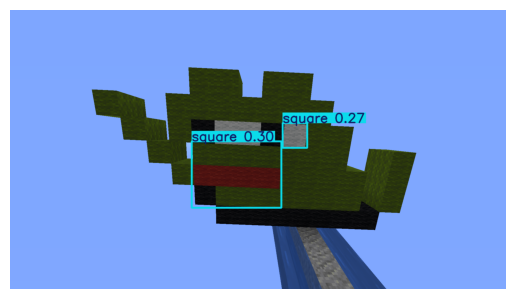

In [30]:
# test model on a test image
image_path = "test_images/image6.png" # path to the test image

# Load the trained model
trained_model = YOLO("./runs/detect/yolo_shapes4/weights/best.pt")  

# Run inference
# results = trained_model.predict(source=image_path, save=True, project = "./runs/detect")  # Save output image with detections
results = trained_model.predict(source = image_path, save = False)

# Access the first result and render it
annotated_image = results[0].plot()  # Returns image with bounding boxes (as a NumPy array)

# Display it with matplotlib
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()